<a href="https://colab.research.google.com/github/tyceaddley/Case-Analysis-/blob/master/Case_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from matplotlib import gridspec
from sklearn import linear_model
import plotly.express as px
import plotly


In [42]:
!echo "# Case-Analysis-" >> README.md
!git init
!git add README.md
!git commit -m "first commit"
!git remote add origin git@github.com:tyceaddley/Case-Analysis-.git
!git push -u origin master

Reinitialized existing Git repository in /content/.git/

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@b51b8f3741a6.(none)')
fatal: remote origin already exists.
error: src refspec master does not match any.
error: failed to push some refs to 'git@github.com:tyceaddley/Case-Analysis-.git'


In [43]:
#data frame that is the account sheet
df_acc = pd.read_excel('/content/drive/My Drive/Accounts_.xlsx')
#data frame that is the employee sheet
df_emp = pd.read_excel('/content/drive/My Drive/Employees_.xlsx')
df_emp.columns = df_emp.iloc[0]
df_emp = df_emp.drop(0)
df_emp['Region Name'] = df_emp['Region Name'].replace(['Southwest'],'SouthWest')
df_acc.head()
df_emp.head()

,Employee_ID,Pay Scale,Start Date,End Date,Region Name
1,1413097327,experienced,2015-01-03 00:00:00,NaN,SouthWest
2,9847221026,experienced,2015-01-03 00:00:00,NaN,NorCal
3,4307056431,new,2015-01-14 00:00:00,2015-06-18 00:00:00,SouthWest
4,8732968276,experienced,2015-02-04 00:00:00,2015-08-10 00:00:00,SoCal
5,3184572092,new,2015-07-08 00:00:00,2015-08-10 00:00:00,East Coast


In [44]:
#dropping the pesky time componenet to the datetime object
df_acc['Signed Date'] = pd.to_datetime(df_acc['Signed Date']).dt.normalize()
df_acc['Approved Date'] = pd.to_datetime(df_acc['Approved Date']).dt.normalize()
#change the NULL values in column "Date Cancelled" to 0
df_acc['Date Cancelled'] = df_acc['Date Cancelled'].where(df_acc[['Date Cancelled']].isnull(), 1).fillna(0)
#create cancel Cancel Yes_No column with 0 as not cancelled and 1 as cancelled
df_acc['Cancel_yes_no'] = df_acc['Date Cancelled'].apply(lambda x: int(0) if x == 0  else int(1))
df_acc['Cancel_yes_no'].value_counts()
#fix our Southwest naming typos
df_acc['Region'] = df_acc['Region'].replace(['Southwest'],'SouthWest')
#sort values by date signed 
df_acc.sort_values(by=['Signed Date'])
#create calculated time of approval and time to install columns
df_acc['Signed_to_Approved']=df_acc['Approved Date'].sub(df_acc['Signed Date'], axis=0)
df_acc['Signed_to_Approved'].astype(str)
df_acc['Approved_to_Install']=df_acc['Install Date'].sub(df_acc['Approved Date'], axis=0)

df_acc.head()

,Prospect ID,Date Cancelled,Stage,KW,Signed Date,Approved Date,Cap Approved,Permit Approved,Install Date,Employee_ID,Region,Cancel_yes_no,Signed_to_Approved,Approved_to_Install
0,1273323812,0,Approved,7.28,2015-06-03,2015-06-05,2015-06-12,2015-06-15,2015-06-15,1066888213,NorCal,0,2 days,10 days
1,1648539303,0,Approved,5.20,2015-06-05,2015-06-08,2015-06-12,2015-06-25,2015-06-16,1740224479,NorCal,0,3 days,8 days
2,7861322731,0,Approved,8.32,2015-06-05,2015-06-08,2015-06-17,2015-06-25,2015-06-22,1740224479,NorCal,0,3 days,14 days
3,1550938149,0,Approved,8.06,2015-06-12,2015-06-16,2015-06-19,2015-06-29,2015-06-23,1066888213,NorCal,0,4 days,7 days
4,9822187121,0,Approved,4.68,2015-06-04,2015-06-05,2015-06-18,2015-06-24,2015-06-24,8891259136,East Coast,0,1 days,19 days


In [45]:
df_acc.dtypes

Prospect ID                      int64
Date Cancelled                  object
Stage                           object
KW                             float64
Signed Date             datetime64[ns]
Approved Date           datetime64[ns]
Cap Approved            datetime64[ns]
Permit Approved         datetime64[ns]
Install Date            datetime64[ns]
Employee_ID                      int64
Region                          object
Cancel_yes_no                    int64
Signed_to_Approved     timedelta64[ns]
Approved_to_Install    timedelta64[ns]
dtype: object

In [46]:
df_acc.describe()
#simple statistics of df_acc, need to drop ID's they're NAN

,Prospect ID,KW,Employee_ID,Cancel_yes_no,Signed_to_Approved,Approved_to_Install
count,1.802000e+03,1802.000000,1.802000e+03,1802.000000,1520,885
mean,3.561406e+09,7.198244,3.284231e+09,0.330189,4 days 08:46:44.210526,55 days 07:32:20.338983
std,2.773414e+09,3.107765,2.662506e+09,0.470411,8 days 16:39:15.188329,29 days 03:18:47.061717
min,1.000412e+09,2.600000,1.000950e+09,0.000000,-130 days +00:00:00,3 days 00:00:00
25%,1.473113e+09,4.950000,1.434508e+09,0.000000,1 days 00:00:00,32 days 00:00:00
50%,1.980363e+09,6.600000,1.893708e+09,0.000000,2 days 00:00:00,51 days 00:00:00
75%,5.627093e+09,8.800000,4.937933e+09,1.000000,4 days 00:00:00,74 days 00:00:00
max,9.984938e+09,28.620000,9.918775e+09,1.000000,108 days 00:00:00,152 days 00:00:00


In [47]:
#find the overall cancel rate for all customers in set
def cancel_rate(z):
  percent = (sum(z)/len(z))
  print('Cancel percentage total:'+str(percent))
  
cancel_rate(df_acc.Cancel_yes_no.values)

Cancel percentage total:0.330188679245283


In [48]:
df_acc_rate = df_acc.groupby(['Region','Cancel_yes_no'])['Cancel_yes_no'].count()
print(df_acc_rate)
df_acc_rate.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

Region      Cancel_yes_no
East Coast  0                366
            1                287
NorCal      0                277
            1                 97
SoCal       0                290
            1                112
SouthWest   0                274
            1                 99
Name: Cancel_yes_no, dtype: int64


Region      Cancel_yes_no
East Coast  0                56.049005
            1                43.950995
NorCal      0                74.064171
            1                25.935829
SoCal       0                72.139303
            1                27.860697
SouthWest   0                73.458445
            1                26.541555
Name: Cancel_yes_no, dtype: float64

In [49]:
#KiloWatt number and mean by region
df_acc.groupby(['Region'])['KW'].describe()[['count','mean']]

,count,mean
Region,,
East Coast,653.0,7.613913
NorCal,374.0,6.885521
SoCal,402.0,6.439789
SouthWest,373.0,7.601528


In [50]:
#creating dataframes by region for easier graphing statements
region = df_acc.groupby(df_acc.Region)
df_acc_ec = region.get_group("East Coast")
df_acc_nc = region.get_group("NorCal")
df_acc_sc = region.get_group("SoCal")
df_acc_sw = region.get_group("SouthWest")

In [51]:
#create a plot function that will show larger line plot that standard
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [52]:
#sorting values of new by region dataframes by date signed, ??organization
df_acc_ec = df_acc_ec.sort_values(by=['Signed Date'])
df_acc_nc = df_acc_nc.sort_values(by=['Signed Date'])
df_acc_sc = df_acc_sc.sort_values(by=['Signed Date'])
df_acc_sw = df_acc_sw.sort_values(by=['Signed Date'])

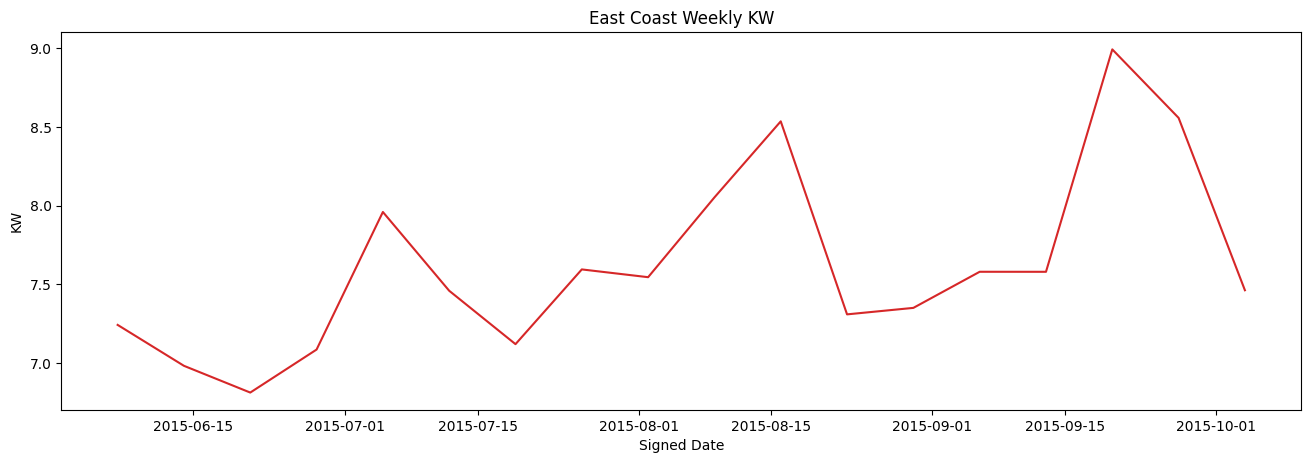

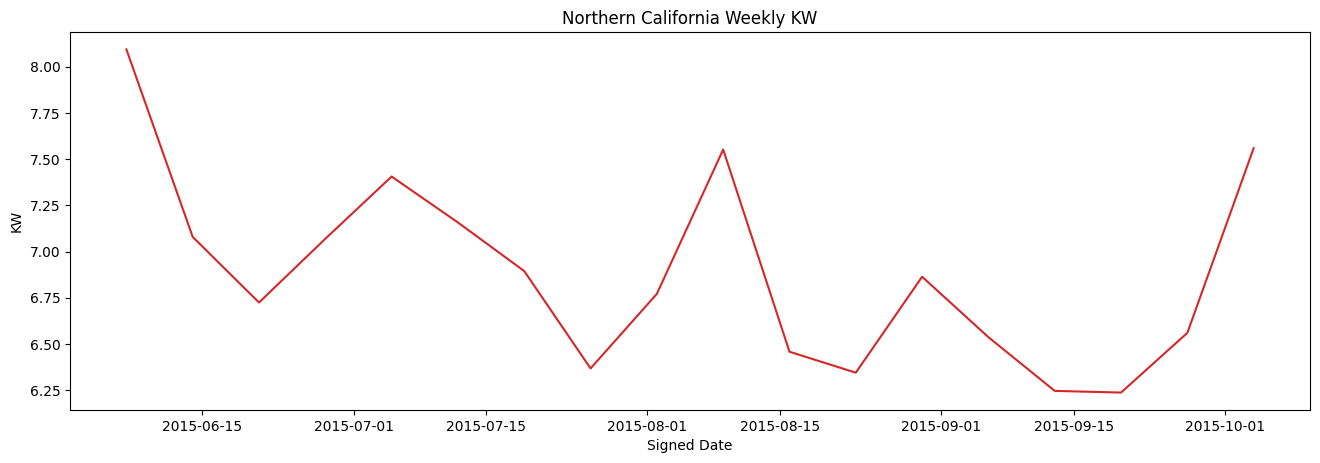

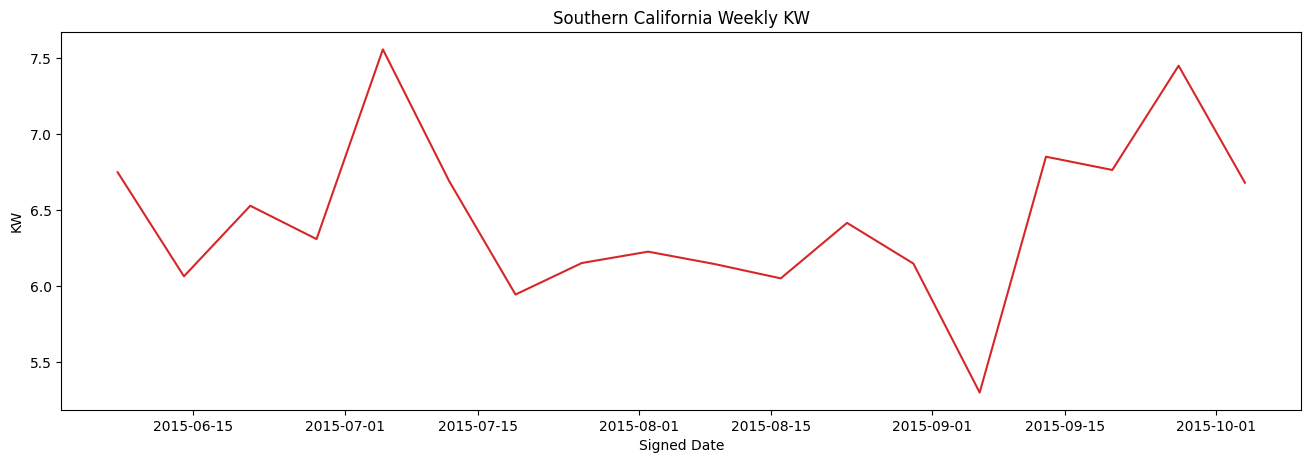

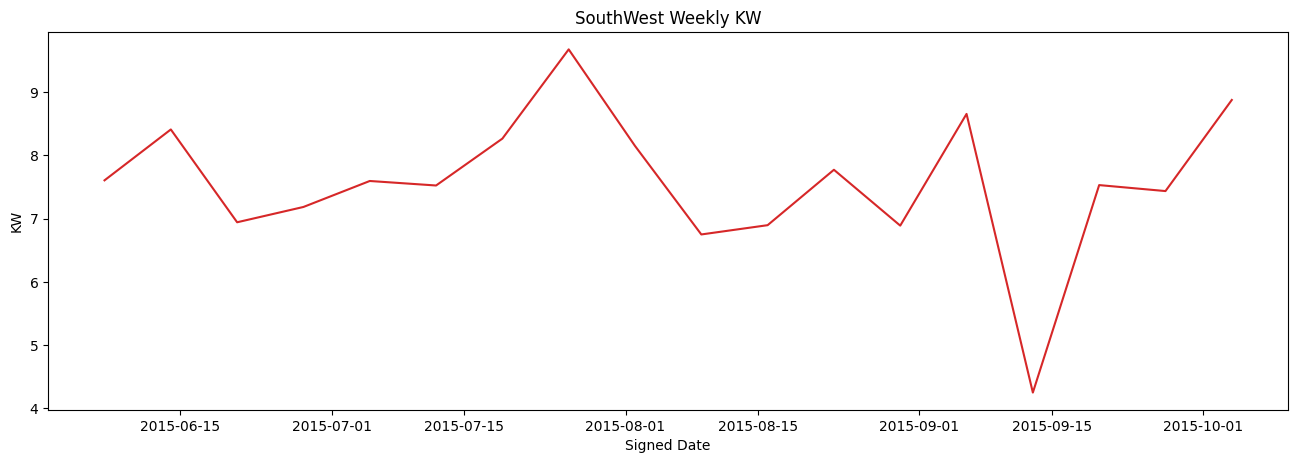

In [53]:
#resample by weekly count for trend identification
df_sampled_ec = df_acc_ec.set_index('Signed Date').resample('W').mean().reset_index()
df_sampled_nc = df_acc_nc.set_index('Signed Date').resample('W').mean().reset_index()
df_sampled_sc = df_acc_sc.set_index('Signed Date').resample('W').mean().reset_index()
df_sampled_sw = df_acc_sw.set_index('Signed Date').resample('W').mean().reset_index()
#creating x and y variables to compare date signed and the size of the system purchased/installed
x_ec = df_sampled_ec['Signed Date']
y_ec = df_sampled_ec['KW'] 

x_nc = df_sampled_nc['Signed Date']
y_nc = df_sampled_nc['KW'] 

x_sc = df_sampled_sc['Signed Date']
y_sc = df_sampled_sc['KW'] 

x_sw = df_sampled_sw['Signed Date']
y_sw = df_sampled_sw['KW'] 
#print the plots for the 4 different regions:
plot_df(df_sampled_ec, x_ec, y_ec, title='East Coast Weekly KW', xlabel='Signed Date', ylabel='KW',dpi=100)
plot_df(df_sampled_nc, x_nc, y_nc, title='Northern California Weekly KW', xlabel='Signed Date', ylabel='KW',dpi=100)
plot_df(df_sampled_sc, x_sc, y_sc, title='Southern California Weekly KW', xlabel='Signed Date', ylabel='KW',dpi=100)
plot_df(df_sampled_sw, x_sw, y_sw, title='SouthWest Weekly KW', xlabel='Signed Date', ylabel='KW',dpi=100)


In [54]:
#df = px.data.tips()
#fig = px.scatter(df, x=x, y=y, trendline="ols")
#fig.show()

In [55]:
df_acc = df_acc.sort_values(by=['Signed Date'])
df_acc_tot = df_acc.set_index('Signed Date').resample('W').mean().reset_index()

In [58]:
df_acc['Approved_to_Install'] = pd.to_timedelta(df_acc['Approved_to_Install'])
df_acc['Approved_to_Install'] = df_acc['Approved_to_Install'].fillna('0')

In [59]:
df_acc['Approved_to_Install'] = df_acc['Approved_to_Install'].dt.days.astype('int')

In [61]:
fig = px.scatter(df_acc, x=df_acc['Signed Date'], y=df_acc['KW'],
                 size=df_acc['Approved_to_Install'], trendline="ols",
                 title = 'All Region Accounts by Date and KW Size')
#fig.write_image("/content/drive/My Drive/Colab Notebooks/all_accounts_lgcy.jpeg")
fig.show()

In [64]:
df_acc_ec['Approved_to_Install'] = pd.to_timedelta(df_acc_ec['Approved_to_Install'])
df_acc_ec['Approved_to_Install'] = df_acc_ec['Approved_to_Install'].fillna('0')

In [65]:
df_acc_ec['Approved_to_Install'] = df_acc_ec['Approved_to_Install'].dt.days.astype('int')

In [66]:
fig = px.scatter(df_acc_ec, x=df_acc_ec['Signed Date'], y=df_acc_ec['KW'],
                 size=df_acc_ec['Approved_to_Install'], trendline="ols",
                 title = 'East Coast Region Accounts by Date and KW Size')
#fig.write_image("/content/drive/My Drive/Colab Notebooks/eastcoast_lgcy.jpeg")
fig.show()

In [69]:
df_acc_nc['Approved_to_Install'] = pd.to_timedelta(df_acc_nc['Approved_to_Install'])
df_acc_nc['Approved_to_Install'] = df_acc_nc['Approved_to_Install'].fillna('0')

In [70]:
df_acc_nc['Approved_to_Install'] = df_acc_nc['Approved_to_Install'].dt.days.astype('int')

In [71]:
fig = px.scatter(df_acc_nc, x=df_acc_nc['Signed Date'], y=df_acc_nc['KW'],
                 size=df_acc_nc['Approved_to_Install'], trendline="ols",
                 title = 'Northern California Region Accounts by Date and KW Size')
#fig.write_image("/content/drive/My Drive/Colab Notebooks/nocal_lgcy.jpeg")
fig.show()

In [73]:
df_acc_sc['Approved_to_Install'] = pd.to_timedelta(df_acc_sc['Approved_to_Install'])
df_acc_sc['Approved_to_Install'] = df_acc_sc['Approved_to_Install'].fillna('0')

In [74]:
df_acc_sc['Approved_to_Install'] = df_acc_sc['Approved_to_Install'].dt.days.astype('int')

In [75]:
fig = px.scatter(df_acc_sc, x=df_acc_sc['Signed Date'], y=df_acc_sc['KW'],
                 size=df_acc_sc['Approved_to_Install'], trendline="ols",
                 title = 'Southern California Region Accounts by Date and KW Size')
#fig.write_image("/content/drive/My Drive/Colab Notebooks/socal_lgcy.jpeg")
fig.show()

In [77]:
df_acc_sw['Approved_to_Install'] = pd.to_timedelta(df_acc_sw['Approved_to_Install'])
df_acc_sw['Approved_to_Install'] = df_acc_sw['Approved_to_Install'].fillna('0')

#fig = px.scatter(df_acc_sw, x=df_acc_sw['Signed Date'], y=df_acc_sw['KW'],size=df_acc_sw['Approved_to_Install'], trendline="ols")
#fig.show()
#print(df_acc_sw.to_string())

In [78]:
df_acc_sw['Approved_to_Install'] = df_acc_sw['Approved_to_Install'].dt.days.astype('int')

In [79]:
fig = px.scatter(df_acc_sw, x=df_acc_sw['Signed Date'], y=df_acc_sw['KW'],
                 size=df_acc_sw['Approved_to_Install'], trendline="ols",
                 title = 'South West Region Accounts by Date and KW Size')
#fig.write_image("/content/drive/My Drive/Colab Notebooks/south_west_lgcy.jpeg")
fig.show()

In [80]:
#create new column defining the NaT values as 0 and dates as 1 for summation
#this will allow calculations for the different regions conversion rates
df_acc['NaT_Signed'] = df_acc['Signed Date'].notnull() * 1
signed_acc = df_acc.groupby('Region')['NaT_Signed'].sum()
print(signed_acc)

Region
East Coast    653
NorCal        374
SoCal         402
SouthWest     373
Name: NaT_Signed, dtype: int64


In [81]:

df_acc['NaT_Approved'] = df_acc['Approved Date'].notnull() * 1
approved_acc = df_acc.groupby('Region')['NaT_Approved'].sum()
print(approved_acc)

Region
East Coast    531
NorCal        315
SoCal         347
SouthWest     327
Name: NaT_Approved, dtype: int64


In [82]:

df_acc['NaT_Install'] = df_acc['Install Date'].notnull() * 1
install_acc = df_acc.groupby('Region')['NaT_Install'].sum()
print(install_acc)


Region
East Coast    235
NorCal        204
SoCal         236
SouthWest     210
Name: NaT_Install, dtype: int64


In [83]:
print('Conversion Rate by Region Accounts Signed to Approved:\n'+str((approved_acc/signed_acc)*100))
print('Conversion Rate by Region Accounts Approved to Installation:\n'+str((install_acc/approved_acc)*100))

Conversion Rate by Region Accounts Signed to Approved:
Region
East Coast    81.316998
NorCal        84.224599
SoCal         86.318408
SouthWest     87.667560
dtype: float64
Conversion Rate by Region Accounts Approved to Installation:
Region
East Coast    44.256121
NorCal        64.761905
SoCal         68.011527
SouthWest     64.220183
dtype: float64


In [84]:
df_acc.groupby('Region').describe()

Prospect ID                              ... NaT_Install          
                 count          mean           std  ...         50%  75%  max
Region                                              ...                      
East Coast       653.0  3.569399e+09  2.741775e+09  ...         0.0  1.0  1.0
NorCal           374.0  3.571332e+09  2.766221e+09  ...         1.0  1.0  1.0
SoCal            402.0  3.433334e+09  2.766253e+09  ...         1.0  1.0  1.0
SouthWest        373.0  3.675490e+09  2.848055e+09  ...         1.0  1.0  1.0

[4 rows x 72 columns]

In [85]:
df_acc['Signed_to_Approved']=df_acc['Signed_to_Approved'].fillna('0')
df_acc['Approved_to_Install']=df_acc['Approved_to_Install'].fillna('0')
df_acc['Signed_to_Approved']=df_acc['Signed_to_Approved'].astype(object)
df_acc['Approved_to_Install']=df_acc['Approved_to_Install'].astype(object)


In [86]:
fig = px.bar(df_acc, x=df_acc['Signed Date'], y=df_acc['Signed_to_Approved'])
fig.show()

In [87]:
df_acc.head()

,Prospect ID,Date Cancelled,Stage,KW,Signed Date,Approved Date,Cap Approved,Permit Approved,Install Date,Employee_ID,Region,Cancel_yes_no,Signed_to_Approved,Approved_to_Install,NaT_Signed,NaT_Approved,NaT_Install
886,1868351613,2015-10-27 00:00:00,Approved,6.50,2015-06-01,2015-06-01,NaT,NaT,NaT,1525108941,SoCal,1,0 days 00:00:00,0,1,1,0
68,1652040865,0,Approved,3.64,2015-06-01,2015-06-02,2015-06-29,2015-07-09,2015-07-27,2113932174,SouthWest,0,1 days 00:00:00,55,1,1,1
251,1658801599,0,Approved,8.06,2015-06-01,2015-06-02,2015-06-17,2015-07-02,2015-08-25,1929747302,SouthWest,0,1 days 00:00:00,84,1,1,1
280,2624576831,0,Approved,4.68,2015-06-01,2015-06-03,2015-06-25,2015-07-08,2015-08-28,1389300154,SouthWest,0,2 days 00:00:00,86,1,1,1
336,6325530283,0,Approved,6.50,2015-06-01,2015-06-03,2015-06-22,2015-08-18,2015-09-03,1959786710,NorCal,0,2 days 00:00:00,92,1,1,1


In [88]:
#df_emp_count = df_acc.groupby(['Region','Employee_ID'])['Region'].count()
emp_counts = df_acc.groupby(['Region', 'Employee_ID'])['Employee_ID'].agg('count').reset_index(name='counts')

emp_sorted_counts = emp_counts.sort_values(['Region','counts'], ascending=[True, False])

emp_sorted_counts.groupby('Region').head(3)

,Region,Employee_ID,counts
97,East Coast,6054580687,33
34,East Coast,1588936664,24
3,East Coast,1083891097,21
143,NorCal,1924712694,36
121,NorCal,1066888213,34
161,NorCal,7500049289,29
171,SoCal,1123632520,56
200,SoCal,4937933091,39
172,SoCal,1151169903,35
242,SouthWest,1700474172,31


In [89]:
emp_combined = pd.merge(left=df_emp, right=emp_sorted_counts, how='left', left_on='Employee_ID', right_on='Employee_ID')
emp_combined = emp_combined.drop('Region',1)
emp_combined = emp_combined.sort_values(['counts'], ascending=False)
emp_combined['Start Date'] = pd.to_datetime(emp_combined['Start Date'])
emp_combined['End Date'] = pd.to_datetime(emp_combined['End Date'])

print(emp_combined.to_string())

     Employee_ID    Pay Scale Start Date   End Date Region Name  counts
325   1123632520      manager 2014-09-12        NaT       SoCal    56.0
10    4937933091      manager 2015-01-23        NaT       SoCal    39.0
6     1924712694      manager 2015-01-20        NaT      NorCal    36.0
243   1151169903      manager 2015-06-16        NaT       SoCal    35.0
324   1066888213      manager 2014-09-13        NaT      NorCal    34.0
220   6054580687  experienced 2015-05-26        NaT  East Coast    33.0
17    1700474172  experienced 2015-02-02        NaT   SouthWest    31.0
158   7500049289  experienced 2015-04-27        NaT      NorCal    29.0
304   1740224479  experienced 2014-11-12        NaT      NorCal    27.0
52    5697496678  experienced 2015-03-01        NaT       SoCal    26.0
213   2021239843  experienced 2015-05-22        NaT      NorCal    25.0
113   1588936664  experienced 2015-04-16        NaT  East Coast    24.0
115   1879076280  experienced 2015-04-16        NaT       SoCal 

In [90]:
emp_combined['tenure']=emp_combined['End Date'].sub(emp_combined['Start Date'],axis=0)

emp_combined = emp_combined.fillna('0')

emp_combined['employed_01'] = np.where(emp_combined['tenure'].eq('0'), 0, 1)
print(emp_combined.to_string())

     Employee_ID    Pay Scale Start Date             End Date Region Name counts             tenure  employed_01
325   1123632520      manager 2014-09-12                    0       SoCal     56                  0            0
10    4937933091      manager 2015-01-23                    0       SoCal     39                  0            0
6     1924712694      manager 2015-01-20                    0      NorCal     36                  0            0
243   1151169903      manager 2015-06-16                    0       SoCal     35                  0            0
324   1066888213      manager 2014-09-13                    0      NorCal     34                  0            0
220   6054580687  experienced 2015-05-26                    0  East Coast     33                  0            0
17    1700474172  experienced 2015-02-02                    0   SouthWest     31                  0            0
158   7500049289  experienced 2015-04-27                    0      NorCal     29                

In [91]:
#calculate the retention rate of employees by region
quitters = emp_combined.groupby(['Region Name','employed_01'])['employed_01'].count()
print(quitters)
#compute the percentage of still employed vs quit
quitters.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

Region Name  employed_01
East Coast   0              99
             1              18
NorCal       0              45
             1              15
SoCal        0              39
             1              12
SouthWest    0              86
             1              13
Name: employed_01, dtype: int64


Region Name  employed_01
East Coast   0              84.615385
             1              15.384615
NorCal       0              75.000000
             1              25.000000
SoCal        0              76.470588
             1              23.529412
SouthWest    0              86.868687
             1              13.131313
Name: employed_01, dtype: float64

In [92]:
emp_combined['counts'] = emp_combined['counts'].astype(int)
greater_than5 = emp_combined[emp_combined["counts"] >= 5].count()["employed_01"]
less_than5 = emp_combined[emp_combined["counts"] < 5].count()["employed_01"]

print(len(emp_combined))
print(greater_than5)
print(less_than5)

327
118
209


In [93]:
quit_gt5=emp_combined[(emp_combined['counts']>=5)&(emp_combined['employed_01']==1)].sum()
quit_lt5=emp_combined[(emp_combined['counts']<5)&(emp_combined['employed_01']==1)].sum()
print(quit_gt5['employed_01'])
print(quit_lt5['employed_01'])
#df[(df.a > 1) & (df.a < 3)].sum()

14
44


In [94]:
all_quit = emp_combined[emp_combined['employed_01']==1]
all_quit = all_quit.sort_values(['tenure'])
#print(all_quit)
emp_combined = pd.merge(left=df_acc, right=emp_combined, how='left', left_on='Employee_ID', right_on='Employee_ID')

In [95]:
quit_emp_acc = pd.merge(left=df_acc, right=all_quit, how='left', left_on='Employee_ID', right_on='Employee_ID')
quit_emp_acc = quit_emp_acc.sort_values('tenure')
quit_emp_acc = quit_emp_acc.drop(columns=['Prospect ID','Date Cancelled','Approved Date','Cap Approved',
                              'Permit Approved','Install Date','Region',
                                 'Signed_to_Approved','Approved_to_Install',
                                 'NaT_Signed','NaT_Approved','NaT_Install'],axis=1)
quit_emp_acc = quit_emp_acc.fillna(0)
quit_emp_acc = quit_emp_acc[quit_emp_acc['employed_01']!= 0]
a = quit_emp_acc.count()
#print(a)
#print(quit_emp_acc.to_string())

In [96]:
quit_emp_acc['tenure'] = pd.to_timedelta(quit_emp_acc['tenure'])
quit_emp_acc['tenure'] = quit_emp_acc['tenure'].dt.days
quit_emp_acc['Start Date'] = pd.to_datetime(quit_emp_acc['Start Date'])

In [97]:
quit_emp_acc['kw_per_day'] = (quit_emp_acc['KW'])/(quit_emp_acc['tenure'])
quit_emp_acc['day_to_first_sale'] = (quit_emp_acc['Signed Date'])-(quit_emp_acc['Start Date'])
quit_emp_acc['day_to_first_sale'] = pd.to_timedelta(quit_emp_acc['day_to_first_sale'])
quit_emp_acc['day_to_first_sale'] = quit_emp_acc['day_to_first_sale'].dt.days
lt_5_emp = quit_emp_acc.loc[quit_emp_acc['counts'] < 5]
print(lt_5_emp.to_string())

         Stage      KW Signed Date  Employee_ID  Cancel_yes_no    Pay Scale Start Date             End Date Region Name  counts  tenure  employed_01  kw_per_day  day_to_first_sale
907   Inactive   3.850  2015-07-21   3184572092              0          new 2015-07-08  2015-08-10 00:00:00  East Coast     1.0      33          1.0    0.116667                 13
681   Approved   4.160  2015-07-08   2121291037              1  experienced 2015-07-03  2015-08-24 00:00:00      NorCal     1.0      52          1.0    0.080000                  5
939   Inactive   6.875  2015-07-24   1662723166              0  experienced 2015-07-20  2015-09-28 00:00:00  East Coast     4.0      70          1.0    0.098214                  4
1183  Approved  12.650  2015-08-07   1662723166              0  experienced 2015-07-20  2015-09-28 00:00:00  East Coast     4.0      70          1.0    0.180714                 18
1234  Inactive   7.425  2015-08-12   1662723166              0  experienced 2015-07-20  2015-09-28 0

In [98]:
lt_5_emp.groupby(['Employee_ID'])['day_to_first_sale'].mean()

Employee_ID
1000949916     16.000000
1003632034     55.000000
1199971787      8.500000
1343978066    131.000000
1390708167     14.000000
1394376720    244.000000
1436914890     29.000000
1507430671    200.000000
1592661951     45.500000
1648091763    232.000000
1662723166     18.500000
1667541847     45.000000
1688409640    127.000000
1689560358     50.333333
1775933164    119.000000
1797278881    137.750000
1836172496    252.500000
1854899003     44.000000
1866907657     59.666667
1924021910    170.000000
1960042748    297.250000
2024401043     26.000000
2026823547    185.500000
2048118040     23.000000
2121291037      5.000000
2223332171    153.000000
2717526489     32.000000
3184572092     13.000000
4185409101     83.000000
5571401633    178.000000
6705394741    185.000000
7819493438     18.500000
8029439606     45.000000
8554100086     38.000000
8732968276    143.500000
8853898427    146.000000
9222055691    187.250000
9842381711    148.000000
Name: day_to_first_sale, dtype: float6

In [99]:
lt_5_emp['KW'].mean()

7.702430555555556

In [100]:
gt_5_emp = quit_emp_acc.loc[quit_emp_acc['counts'] >= 5]
gt_5_emp['KW'].mean()

6.9362595419847315

In [101]:
nq_gt_5 = emp_combined.loc[emp_combined['counts'] >= 5]
nq_lt_5 = emp_combined.loc[emp_combined['counts'] < 5]
print(nq_gt_5['KW'].mean())
print(nq_lt_5['KW'].mean())


7.0806962911126625
7.648579088471845
